## Подготовка

In [2]:
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import pymorphy2
import re
import warnings
import spacy
import en_core_web_sm

warnings.filterwarnings('ignore')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Загрузим данные и посмотрим содержимое

In [3]:
data = pd.read_csv('/datasets/toxic_comments.csv', index_col=0)
display(data.head(5))
display(data.tail(5))

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


,text,toxic
159446,""":::::And for the second time of asking, when ...",0
159447,You should be ashamed of yourself \n\nThat is ...,0
159448,"Spitzer \n\nUmm, theres no actual article for ...",0
159449,And it looks like it was actually you who put ...,0
159450,"""\nAnd ... I really don't think you understand...",0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


Проверим дисбалланас классов

16186

143106

<AxesSubplot:>

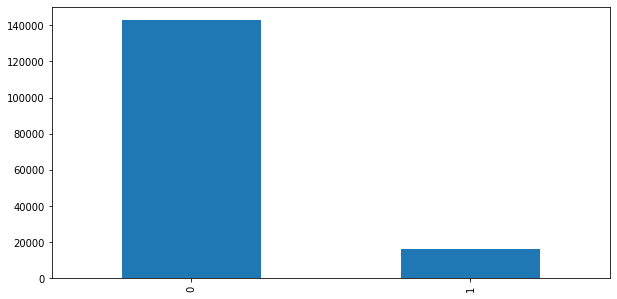

In [6]:
display(data[data['toxic'] == 1].shape[0])
display(data[data['toxic'] == 0].shape[0])
data['toxic'].value_counts().plot(kind='bar', figsize=(10, 5))

Дисбаланс большой, учтем это при обучении модели в дальнейшем.

**Лемматизация и очистка**

Сделаем лемматизацию с помощью SpaCy, переведем текст к нижнему регистру.

In [8]:
data['text'] = data['text'].str.lower()
def clean_text(string):
    string = re.sub(r"[\n\r]", " ", string)
    string = re.sub(r"[^a-zA-Z ]+", "", string)
    return string.strip()

data['text'] = data['text'].apply(clean_text)
display(data.head(5))

,text,toxic
0,explanation why the edits made under my userna...,0
1,daww he matches this background colour im seem...,0
2,hey man im really not trying to edit war its j...,0
3,more i cant make any real suggestions on impro...,0
4,you sir are my hero any chance you remember wh...,0


In [9]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [10]:
def lemmatize(string):
    result = []
    for token in nlp(string):
        if token.is_stop == False:
            result.append(token.lemma_)
    return ' '.join(result)

In [11]:
data['lemma'] = data['text'].apply(lemmatize)
display(data.head(5))

,text,toxic,lemma
0,explanation why the edits made under my userna...,0,explanation edit username hardcore metallica f...
1,daww he matches this background colour im seem...,0,daww match background colour m seemingly stuck...
2,hey man im really not trying to edit war its j...,0,hey man m try edit war guy constantly remove r...
3,more i cant make any real suggestions on impro...,0,not real suggestion improvement wonder secti...
4,you sir are my hero any chance you remember wh...,0,sir hero chance remember page s


**Создание выборок**

Создадим обучающую и тестовую выборку, используем аргумент stratify, чтобы значения целевого признака были равномерно распределены в разных выборках.

In [14]:
features = data['lemma']
target = data['toxic']
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25,
                                                                            random_state=12345, stratify=data['toxic'])
display(features_train.shape[0])
display(features_test.shape[0])

119469

39823

**Векторизация**

In [15]:
stop_words = set(stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=stop_words) 
count_tf_idf.fit(features_train) 
features_train = count_tf_idf.transform(features_train)
features_test = count_tf_idf.transform(features_test)

**Выводы:**

1) Импортировали билиотеки

2) Загрузили данные

3) Изучили содержимое, удалили лишний столбец

4) Провели лемматизацию, очистку и векторизацию.

## Обучение

Попробуем обучить модели:

1) LogisticRegression

2) LinearSVC

**LogisticRegression**

In [16]:
model_LR = LogisticRegression(random_state=12345, class_weight='balanced')
parameters_grid = [{'C': [1, 10]}]

LR_model_gscv = GridSearchCV(model_LR, param_grid=parameters_grid, scoring='f1', n_jobs=-1, verbose=True, cv=3)
LR_model_gscv.fit(features_train, target_train)


Fitting 3 folds for each of 2 candidates, totalling 6 fits


GridSearchCV(cv=3,
             estimator=LogisticRegression(class_weight='balanced',
                                          random_state=12345),
             n_jobs=-1, param_grid=[{'C': [1, 10]}], scoring='f1',
             verbose=True)

In [17]:
display(LR_model_gscv.best_params_)
display(LR_model_gscv.best_score_)
results_LR=pd.DataFrame(LR_model_gscv.cv_results_)

{'C': 10}

0.7653744412876691

**LinearSVC**

In [18]:
parametrs_grid = {'C': [1, 5]}
SVC_model = LinearSVC(random_state=12345, class_weight='balanced')

SVC_model_gscv = GridSearchCV(SVC_model, param_grid=parametrs_grid, scoring='f1', cv=3)

SVC_model_gscv.fit(features_train, target_train)

GridSearchCV(cv=3,
             estimator=LinearSVC(class_weight='balanced', random_state=12345),
             param_grid={'C': [1, 5]}, scoring='f1')

In [19]:
display(SVC_model_gscv.best_params_)
display(SVC_model_gscv.best_score_)
results_SVC=pd.DataFrame(SVC_model_gscv.cv_results_)

{'C': 1}

0.7595471147901417

Лучший результат показала модель LinearRegression. Проверим ее на тестовой выборке.

In [20]:
model_LR = LogisticRegression(random_state=12345, class_weight='balanced', C=10)
model_LR.fit(features_train, target_train)
predictions=model_LR.predict(features_test)
display('F1: {:.4f}'.format(f1_score(target_test, predictions)))

'F1: 0.7646'

**Выводы**

1) Обучили две модели

2) Лучшая модель- LogisticRegression

3) Проверили модель на тестовой выборке, результат выше целевого: F1: 0.7646

## Выводы

1) Импортировали необходимые библиотеки, загрузили данные

2) Изучили данные, обнаружили дисбаланс классов

3) Провели очистку данных, после чего- их лемматизацию и векторизацию

4) Обучили модели, нашли модель с наибольшей точностью- LinearRegression

5) Хотя модель LinearRegression и точнее, модель LinearSVC- быстрее:

In [21]:
display('Время обучения SVC', results_SVC.loc[results_SVC['rank_test_score'] == 1]['mean_fit_time'].values[0])
display('Время предсказания SVC', results_SVC.loc[results_SVC['rank_test_score'] == 1]['mean_score_time'].values[0])

display('Время обучения LR', results_LR.loc[results_LR['rank_test_score'] == 1]['mean_fit_time'].values[0])
display('Время предсказания LR', results_LR.loc[results_LR['rank_test_score'] == 1]['mean_score_time'].values[0])

'Время обучения SVC'

1.5098605155944824

'Время предсказания SVC'

0.013874292373657227

'Время обучения LR'

44.955573638280235

'Время предсказания LR'

0.04329450925191244

Поэтому, если точность для нас отходит на второй план (разница между моделями невелика), то можно сделать выбор и в пользу модели LinearSVC.

6) Обе модели показали результат выше целевого.